<a href="https://colab.research.google.com/github/willdphan/rice-cnn/blob/main/Rice_Classifier_CNN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Rice Classification

> ## About this Notebook
This notebook focuses on the [rice](https://www.kaggle.com/datasets/muratkokludataset/rice-image-dataset) image dataset on Kaggle, consisting of images of different rice varieties. The objective is to develop a machine learning model for accurate classification of rice images into their respective categories.

> ## Objective
The goal is to build a robust machine learning model capable of accurately classifying rice images into their respective varieties. This can assist in various applications such as agricultural research, crop management, and quality control in the rice industry.

> ## Steps to CNN

>>[Import Libraries](#scrollTo=d0701b44)

>>[Open Dataset and Define Classes](#scrollTo=0813746c)

>>[Get Image and Data Size](#scrollTo=a1b96d65)

>>[Define Device](#scrollTo=163982ff)

>>[Define Hyperparameters](#scrollTo=zRWFH8SYW7eq)

>>[Create Transform Variable](#scrollTo=B0c4Jv5YYh87)

>>[Split into Train, Test, Valid Datsets](#scrollTo=I5L2pzj1bCG7)

>>[Use DataLoader for Batch Size](#scrollTo=41a71af4)

>>[Display Images](#scrollTo=cBaVopALVzEs)

>>[CNN Model](#scrollTo=806e4cfa)

>>[Save Model to Device](#scrollTo=L9BfUJJqiV5b)

>>[Define Loss and Optimizer](#scrollTo=7a38cd49)

>>[Train Function](#scrollTo=MeQpWljZ9T8B)

>>[Validation Function](#scrollTo=G6H_hS-X9XJ1)

>>[Define Loss Function and Optimizer](#scrollTo=8yuPQxaZVZXw)

>>[Test Model with Image from Test Dataset](#scrollTo=43bec7de)



### Import Libraries

In [79]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision
import torchvision.transforms as transforms
from torch.utils.data import DataLoader, Dataset
from torchvision.transforms import ToTensor
import torchvision.transforms as tt
from torchvision.datasets import ImageFolder
from torchvision.utils import make_grid
from torchvision import transforms, utils, datasets, models
from torch.autograd import Variable
import glob
import os
import numpy as np
import pandas as pd
import matplotlib as mpl
import matplotlib.pyplot as plt
import pathlib
import zipfile
from torch.utils.data import random_split


### Open Dataset and Define Classes

In [80]:
zip_path = '/content/sample_data/rice.zip'
extract_path = '/content/sample_data'

# 'r' represents to execute in read mode
with zipfile.ZipFile(zip_path, 'r') as zip_ref:
    zip_ref.extractall(extract_path)

In [81]:
path = pathlib.Path("/content/sample_data/Rice_Image_Dataset")

In [82]:
arborio = list(path.glob('Arborio/*'))
basmati = list(path.glob('Basmati/*'))
ipsala = list(path.glob('Ipsala/*'))
jasmine = list(path.glob('Jasmine/*'))
karacadag = list(path.glob('Karacadag/*'))

total_list=arborio + basmati + ipsala + jasmine + karacadag

### Get Image and Data Size

The photos we have are 250 x 250 pixels and each one is 3D. We have a total of 75,000 photos, which are divided into 15,000 collections

In [83]:
data_transform = torchvision.transforms.Compose(
    [
        torchvision.transforms.ToTensor()
    ]
)

model_dataset = datasets.ImageFolder(path, transform=data_transform)

image, label = model_dataset[0]
print(f"Image Size: {image.shape}")
print(f"Label: {label}")
print(image)

Image Size: torch.Size([3, 250, 250])
Label: 0
tensor([[[0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         ...,
         [0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.]],

        [[0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         ...,
         [0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.]],

        [[0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         ...,
         [0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.]]])


### Define Device

In [84]:
device= 'cuda' if torch.cuda.is_available() else 'cpu'

### Define Hyperparameters

In [85]:
epochs = 5
BATCH_SIZE=256

In [86]:
train_count = int(0.7 * len(total_list))
valid_count = int(0.2 * len(total_list))
test_count = len(total_list) - train_count - valid_count
train_dataset, valid_dataset, test_dataset = torch.utils.data.random_split(model_dataset, (train_count, valid_count, test_count))

### Create Transform Variable
Create one transform variable to transform all data at once. Then, split the data into train, valid, and test datasets. Doing it all at once is easier.

We write the operation that we will do on the image with `transforms.Compose`

`Resize` - We make our image 100x100, this gives us speed in terms of processing power.

`RandomHorizontalFlip` - Gives random angles to the image

`ToTensor` - converts image to tensor (tensors are like numpy but more useful for multidimensional operations)

`ImageFolder` - It allows us to combine the conversion process with our image and divide them into 5 classes.

In [87]:
data_transform = torchvision.transforms.Compose(
    [
        torchvision.transforms.Resize((100,100)),
        torchvision.transforms.RandomHorizontalFlip(),
        torchvision.transforms.ToTensor(),
        torchvision.transforms.Normalize(
            mean=[0.5,0.5,0.5], std=[0.5,0.5,0.5]
        ),
    ]
)

In [88]:
model_dataset = datasets.ImageFolder(path, transform=data_transform)

### Split into Train, Test, Valid Datsets

In [89]:
train_count = int(0.7 * len(total_list))
valid_count = int(0.2 * len(total_list))
test_count = len(total_list) - train_count - valid_count

train_dataset, valid_dataset, test_dataset = random_split(model_dataset, (train_count, valid_count, test_count))

### Use DataLoader for Batch Size

In [90]:
train_dataset_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
valid_dataset_loader = DataLoader(valid_dataset, batch_size=BATCH_SIZE, shuffle=True)
test_dataset_loader  = DataLoader(test_dataset , batch_size=BATCH_SIZE, shuffle=False)
dataloaders = {'train': train_dataset_loader, 'val': valid_dataset_loader, 'test': test_dataset_loader}

### Display Images

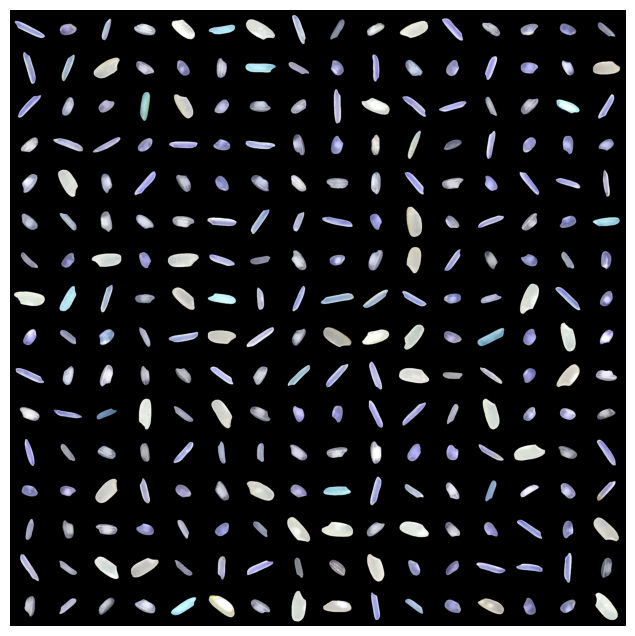

In [91]:
for item in train_dataset_loader:
    plt.figure(figsize=(16, 8))
    image, _ = item
    plt.imshow(make_grid(image, nrow=16).permute(1, 2, 0))
    plt.axis("off")
    plt.show()
    break


### CNN Model

Pay attention to is the number of inputs and hidden layers. By increasing this number, the processing load of training increases.

* `Conv2d` is a module that takes our layers to the hidden layer. kernel_size is the size of the filtering kernel, here we have chosen the 3e3 kernel

* `BatchNorm2d` Usually used after conv2d, used to normalize batches.

* `Relu` activation function. To enhance the non-linearity feature

* `Maxpool2d` is a layer that re-routes the images with the collected data and converts them to a smaller output.

* `fc (fully connected layer)` is the layer that transforms the data from the hidden layers to the output we need. By viewing, the size and handle of the last layer are multiplied and smoothed, then exported to fc and output.

In [92]:
class ConvNet(nn.Module):
    def __init__(self,number_of_classes):
        super().__init__() #Inheritance

        self.conv1 = nn.Conv2d(in_channels=3,out_channels=12,padding=1,kernel_size=3)
        self.bn1 = nn.BatchNorm2d(num_features=12)
        self.relu1 = nn.ReLU()
        self.pool1 = nn.MaxPool2d(kernel_size=2)

        self.conv2 = nn.Conv2d(in_channels=12,out_channels=20,padding=1,kernel_size=3)
        self.bn2 = nn.BatchNorm2d(num_features=20)
        self.relu2 = nn.ReLU()

        self.conv3 = nn.Conv2d(in_channels=20,out_channels=32,padding=1,kernel_size=3)
        self.bn3 = nn.BatchNorm2d(num_features=32)
        self.relu3 = nn.ReLU()
        self.pool3 = nn.MaxPool2d(kernel_size=2)


        self.fc1 = nn.Linear(32*25*25, 5)


    def forward(self, Input):

        output = self.conv1(Input)
        output = self.bn1(output)
        output = self.relu1(output)
        output = self.pool1(output)

        output = self.conv2(output)
        output = self.bn2(output)
        output = self.relu2(output)

        output = self.conv3(output)
        output = self.bn3(output)
        output = self.relu3(output)
        output = self.pool3(output)

        output = torch.flatten(output, 1)
        output = output.view(-1,32*25*25)
        output = self.fc1(output)

        return output

### Save Model to Device

In [93]:
model = ConvNet(5)
model = model.to(device)
model

CustomizedConvNet(
  (conv1): Conv2d(3, 12, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (bn1): BatchNorm2d(12, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu1): ReLU()
  (pool1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv2): Conv2d(12, 20, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (bn2): BatchNorm2d(20, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu2): ReLU()
  (conv3): Conv2d(20, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (bn3): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu3): ReLU()
  (pool3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (fc1): Linear(in_features=20000, out_features=5, bias=True)
)

In [98]:
class DeviceDataLoader():
    def __init__(self, dl, device):
        self.dl = dl
        self.device = device

    def __iter__(self):
        for x in self.dl:
            yield to_device(x, self.device)

train_dataset_loader= DeviceDataLoader(train_dataset_loader, device)
valid_dataset_loader = DeviceDataLoader(valid_dataset_loader, device)

### Define Loss and Optimizer

In [99]:
Loss = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.0001)

### Train Function

In [100]:
def train(epochs):
    history = []
    total_samples = 0  # Keep track of the total number of samples processed
    total_correct = 0  # Keep track of the total number of correct predictions
    total_predictions = 0  # Keep track of the total number of predictions made
    total_loss = 0.0  # Keep track of the total loss

    for epoch in range(epochs):
        model.train()  # Set the model to training mode

        epoch_loss = 0.0

        for image, label in train_dataset_loader:
            image = image.to(device)
            label = label.to(device)

            optimizer.zero_grad()

            out = model(image)
            loss = Loss(out, label)
            loss.backward()
            optimizer.step()

            batch_size = image.size(0)  # Get the batch size
            epoch_loss += loss.item() * batch_size
            total_samples += batch_size

            # get predicted class
            _, predicted = torch.max(out, 1)
            total_correct += (predicted == label).sum().item()
            total_predictions += batch_size

        avg_epoch_loss = epoch_loss / total_samples
        epoch_accuracy = total_correct / total_predictions

        # print epoch stats
        print(f"Epoch [{epoch+1}/{epochs}], Epoch Loss: {avg_epoch_loss}, Epoch Accuracy: {epoch_accuracy}")

        history.append({"Epoch Loss": avg_epoch_loss, "Epoch Accuracy": epoch_accuracy})

        # add epoch loss to total loss
        total_loss += epoch_loss

    # calc average loss and accuracy
    total_avg_loss = total_loss / total_samples
    total_avg_accuracy = total_correct / total_predictions

    print({"Average Training Loss": total_avg_loss, "Average Training Accuracy": total_avg_accuracy})

    return history


### Validation Function

In [101]:
def accuracy(pred, label):
    _, out = torch.max(pred, dim=1)
    return torch.tensor(torch.sum(out == label).item() / len(pred))

# validation function
def validation():
    total_loss = 0.0
    total_acc = 0.0
    total_samples = 0

    for image, label in valid_dataset_loader:
        model.eval()  # Set the model to evaluation mode
        image = image.to(device)
        label = label.to(device)

        out = model(image)
        loss = Loss(out, label)
        # get accuracy from accuracy func above
        acc = accuracy(out, label)

        total_loss += loss.item() * image.size(0)
        total_acc += acc.item() * image.size(0)
        total_samples += image.size(0)

    avg_loss = total_loss / total_samples
    avg_acc = total_acc / total_samples

    print({"Average Validation Loss": avg_loss, "Average Validation Accuracy": avg_acc})

    return {"Average Validation Loss": avg_loss, "Average Validation Accuracy": avg_acc}

### Call Train and Validate Function

In [102]:
train_result = train(5)
validation_result = validation()

Epoch [1/5], Epoch Loss: 0.20360690899860293, Epoch Accuracy: 0.945047619047619
Epoch [2/5], Epoch Loss: 0.01806308498389664, Epoch Accuracy: 0.9680571428571428
Epoch [3/5], Epoch Loss: 0.008680605534671081, Epoch Accuracy: 0.9762222222222222
Epoch [4/5], Epoch Loss: 0.005600181309967524, Epoch Accuracy: 0.9805333333333334
Epoch [5/5], Epoch Loss: 0.003965212360011148, Epoch Accuracy: 0.9832647619047619
{'Average Training Loss': 0.061600336522067055, 'Average Training Accuracy': 0.9832647619047619}
{'Average Validation Loss': 0.020539906120300294, 'Average Validation Accuracy': 0.9933999999046326}


### Test Model with Image from Test Dataset

Compare the predicted result with the result from the Test Dataset.

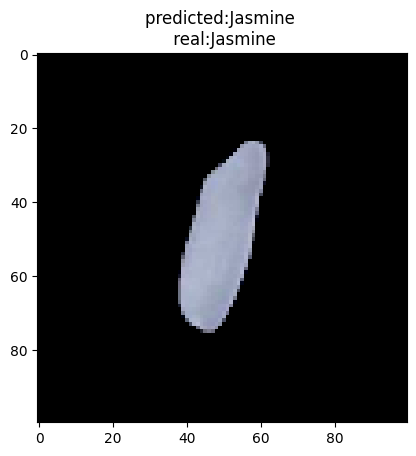

In [103]:
model = model.cpu()
with torch.no_grad():

    for img,label in test_dataset_loader:
        imgs = img[10]
        labels = label[10]
        output_model = imgs.unsqueeze(0)
        output_model = model(output_model)
        index = output_model.argmax()
        imgs = torch.permute(imgs,(1,2,0))
        plt.imshow(imgs)
        plt.title(f"predicted:{ model_dataset.classes[index]} \n real:{ model_dataset.classes[labels]}")
        break